In [ ]:
!pip install -r ../requirements.txt
%%hide output

In [131]:
!mkdir data
!curl https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet --output "data/green_tripdata_2021-01.parquet"
!curl https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet --output "data/green_tripdata_2021-02.parquet"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1302k  100 1302k    0     0  1184k      0  0:00:01  0:00:01 --:--:-- 1183k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1118k  100 1118k    0     0   915k      0  0:00:01  0:00:01 --:--:--  915k


In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [179]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda tm: tm.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df['PU_DO'] = df['PULocationID'].astype(str) + "_" + df['DOLocationID'].astype(str) 
    categorical = ["PU_DO",'PULocationID', 'DOLocationID']
    numerical = ['duration']
    df[categorical] = df[categorical].astype(str)
    return df


In [180]:
df_train = read_dataframe("data/green_tripdata_2021-01.parquet")
df_val = read_dataframe("data/green_tripdata_2021-02.parquet")

In [181]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333,43_151
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000,166_239
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667,41_42
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333,168_75
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667,75_75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000,81_90
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000,35_213
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000,74_69
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000,168_215


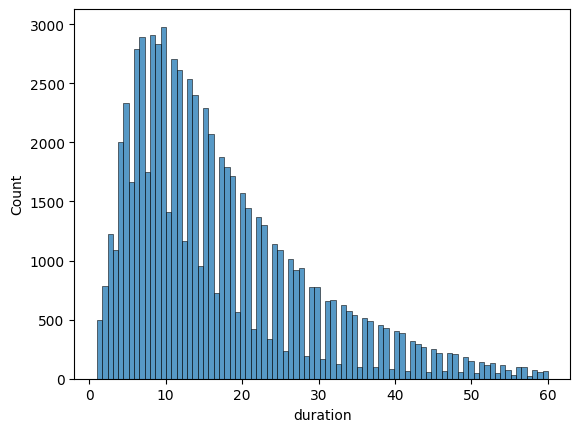

In [182]:
sns.histplot(df_train.duration)
plt.show()

In [183]:
train_dicts = df_train[categorical + numerical].to_dict(orient="records")
val_dicts = df_val[categorical + numerical].to_dict(orient="records")


In [184]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
y_train = df_train["duration"].values
y_val = df_val["duration"].values


In [188]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)


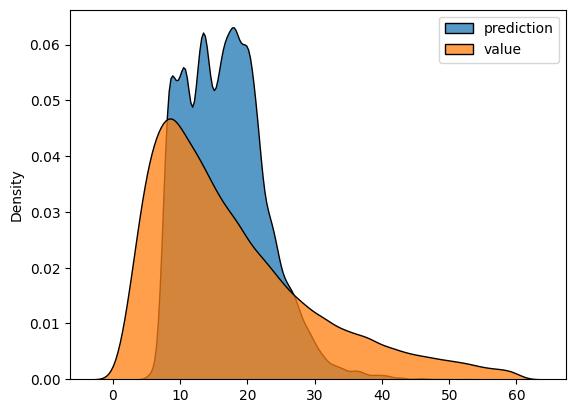

In [189]:
sns.kdeplot(y_pred, label="prediction",multiple="stack")
sns.kdeplot(y_val, label="value",multiple="stack")
plt.legend()
plt.show()

In [187]:
mean_squared_error(y_val, y_pred)

149.14718901091342